[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/027_pytorch_intro/pytorch_intro.ipynb)

# Pytorch - MLP

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline
import random

# Preprocesamiento

In [2]:
import os
from PIL import Image
import glob


dataset_path = "bloodcells_dataset"

classes = ['BASOPHIL', 'EOSINOPHIL', 'ERYTHROBLAST', 'IG', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL', 'PLATELET']

X = []
Y = []


img_size = 28


for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    
    if not os.path.exists(class_path):
        print(f"Advertencia: No se encuentra la carpeta {class_path}")
        continue

    image_paths = glob.glob(os.path.join(class_path, '*.jpg')) + \
                  glob.glob(os.path.join(class_path, '*.jpeg')) + \
                  glob.glob(os.path.join(class_path, '*.png'))

    print(f"Cargando {len(image_paths)} imágenes de la clase {class_name}")

    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_size, img_size))
            img_array = np.array(img).reshape(-1) / 255.0
            X.append(img_array)
            Y.append(class_idx)
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.int64) 


print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de Y: {Y.shape}")

Cargando 1218 imágenes de la clase BASOPHIL
Cargando 3117 imágenes de la clase EOSINOPHIL
Cargando 1551 imágenes de la clase ERYTHROBLAST
Cargando 2895 imágenes de la clase IG
Cargando 1214 imágenes de la clase LYMPHOCYTE
Cargando 1420 imágenes de la clase MONOCYTE
Cargando 3329 imágenes de la clase NEUTROPHIL
Cargando 2348 imágenes de la clase PLATELET
Tamaño de X: (17092, 2352)
Tamaño de Y: (17092,)


# Visualización de prueba

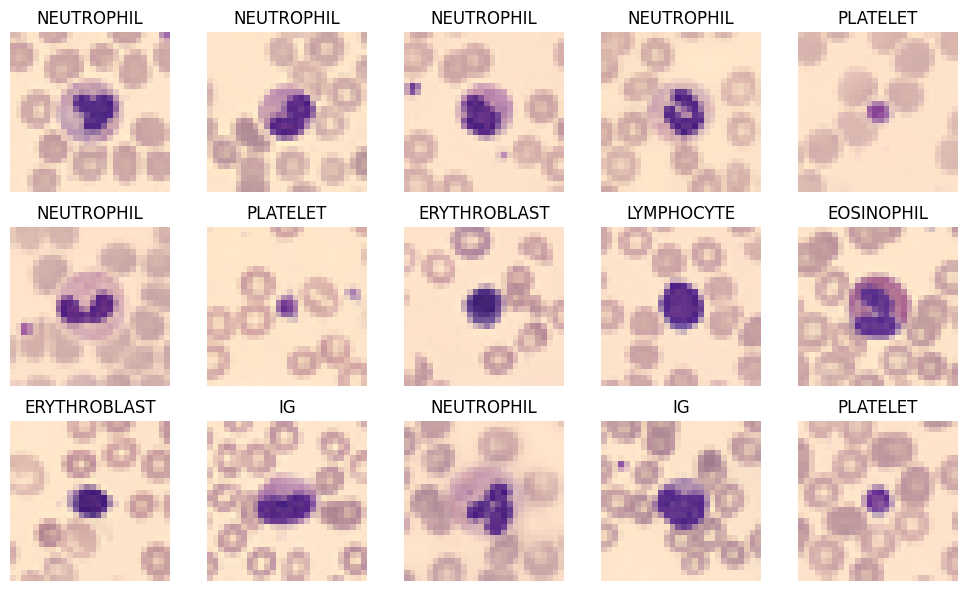

In [3]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        
        img_reshaped = img.reshape(28, 28, 3)
        
    
        plt.imshow(img_reshaped)
        plt.axis("off")
        
        class_names = ['BASOPHIL', 'EOSINOPHIL', 'ERYTHROBLAST', 'IG', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL', 'PLATELET']
        plt.title(class_names[Y[ix]])
        
plt.tight_layout()
plt.show()

# División Aleatoria de Datos en Conjuntos de Entrenamiento y Prueba

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape} imágenes, {y_train.shape} etiquetas")
print(f"Datos de prueba: {X_test.shape} imágenes, {y_test.shape} etiquetas")

Datos de entrenamiento: (13673, 2352) imágenes, (13673,) etiquetas
Datos de prueba: (3419, 2352) imágenes, (3419,) etiquetas


# Entrenamiento

In [5]:
X_train = torch.from_numpy(X).float().cuda()
Y_train = torch.from_numpy(Y).long().squeeze().cuda()

D_in = 3 * 28 * 28  
H1 = 1024
H2 = 512
H3 = 256
D_out = 8  


w1 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (D_in + H1)), (D_in, H1)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)
w2 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (H1 + H2)), (H1, H2)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)
w3 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (H2 + H3)), (H2, H3)), requires_grad=True, device="cuda", dtype=torch.float)
b3 = torch.zeros(H3, requires_grad=True, device="cuda", dtype=torch.float)
w4 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (H3 + D_out)), (H3, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b4 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = -logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    return loss.mean()

epochs = 1000
lr = 0.01  
log_each = 10
loss_history = []



for e in range(1, epochs + 1):

    h1 = X_train.mm(w1) + b1
    h1_relu = h1.clamp(min=0)  

    h2 = h1_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)

    h3 = h2_relu.mm(w3) + b3
    h3_relu = h3.clamp(min=0)

    y_pred = h3_relu.mm(w4) + b4

    loss = cross_entropy(y_pred, Y_train)
    loss_history.append(loss.item())

    loss.backward()

    with torch.no_grad():

        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad
        w3 -= lr * w3.grad
        b3 -= lr * b3.grad
        w4 -= lr * w4.grad
        b4 -= lr * b4.grad

        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()
        w3.grad.zero_()
        b3.grad.zero_()
        w4.grad.zero_()
        b4.grad.zero_()

    if e % log_each == 0:
        print(f"Epoch {e}/{epochs} - Loss: {np.mean(loss_history[-log_each:]):.5f}")

    if np.mean(loss_history[-log_each:]) < 0.01:
        print(f"Convergencia alcanzada en época {e}, deteniendo entrenamiento.")
        break

def evaluate(X):
    with torch.no_grad():
        h1 = X.mm(w1) + b1
        h1_relu = h1.clamp(min=0)

        h2 = h1_relu.mm(w2) + b2
        h2_relu = h2.clamp(min=0)

        h3 = h2_relu.mm(w3) + b3
        h3_relu = h3.clamp(min=0)

        y_pred = h3_relu.mm(w4) + b4
        return y_pred.argmax(axis=1)

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())

y_pred = y_pred.cpu().numpy()

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")



Epoch 10/1000 - Loss: 1.95890
Epoch 20/1000 - Loss: 1.89984
Epoch 30/1000 - Loss: 1.89650
Epoch 40/1000 - Loss: 1.85849
Epoch 50/1000 - Loss: 1.83134
Epoch 60/1000 - Loss: 1.81002
Epoch 70/1000 - Loss: 1.78904
Epoch 80/1000 - Loss: 1.77018
Epoch 90/1000 - Loss: 1.74961
Epoch 100/1000 - Loss: 1.72932
Epoch 110/1000 - Loss: 1.70983
Epoch 120/1000 - Loss: 1.68942
Epoch 130/1000 - Loss: 1.66979
Epoch 140/1000 - Loss: 1.64939
Epoch 150/1000 - Loss: 1.63076
Epoch 160/1000 - Loss: 1.60983
Epoch 170/1000 - Loss: 1.58870
Epoch 180/1000 - Loss: 1.57526
Epoch 190/1000 - Loss: 1.52031
Epoch 200/1000 - Loss: 1.59432
Epoch 210/1000 - Loss: 1.49416
Epoch 220/1000 - Loss: 1.47203
Epoch 230/1000 - Loss: 1.57403
Epoch 240/1000 - Loss: 1.44498
Epoch 250/1000 - Loss: 1.41957
Epoch 260/1000 - Loss: 1.54781
Epoch 270/1000 - Loss: 1.40549
Epoch 280/1000 - Loss: 1.45665
Epoch 290/1000 - Loss: 1.38463
Epoch 300/1000 - Loss: 1.42547
Epoch 310/1000 - Loss: 1.41540
Epoch 320/1000 - Loss: 1.38608
Epoch 330/1000 - 


RESULTADOS DE EVALUACIÓN DEL MODELO
Precisión en datos de entrenamiento: 65.45%
Precisión en datos de prueba: 65.05%
Diferencia (train-test): 0.40%

Matriz de confusión:


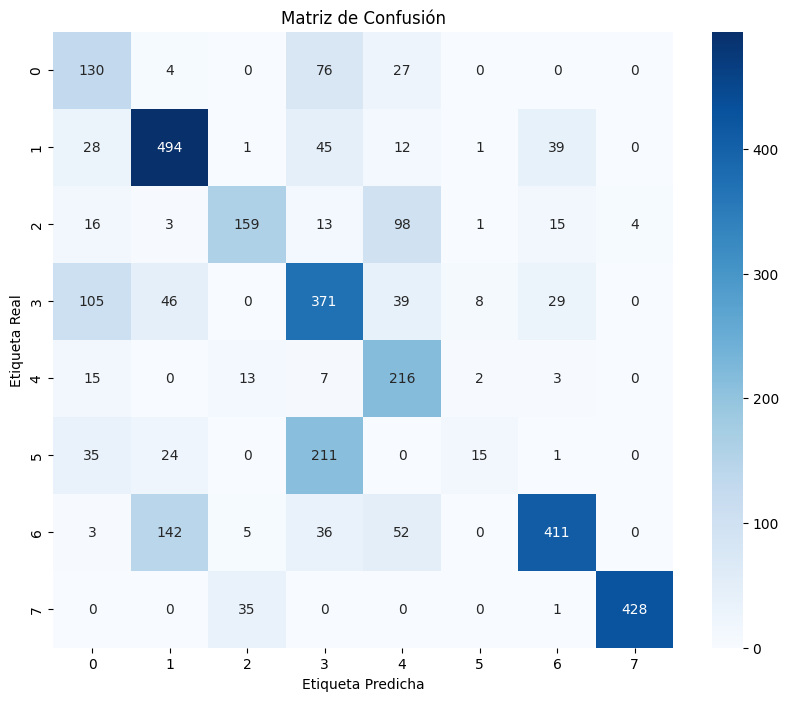


Resumen de métricas por clase:
Clase 0:
  - Precisión: 0.3916
  - Recall: 0.5485
  - F1-score: 0.4569
Clase 1:
  - Precisión: 0.6928
  - Recall: 0.7968
  - F1-score: 0.7412
Clase 2:
  - Precisión: 0.7465
  - Recall: 0.5146
  - F1-score: 0.6092
Clase 3:
  - Precisión: 0.4888
  - Recall: 0.6204
  - F1-score: 0.5468
Clase 4:
  - Precisión: 0.4865
  - Recall: 0.8438
  - F1-score: 0.6171
Clase 5:
  - Precisión: 0.5556
  - Recall: 0.0524
  - F1-score: 0.0958
Clase 6:
  - Precisión: 0.8236
  - Recall: 0.6333
  - F1-score: 0.7160
Clase 7:
  - Precisión: 0.9907
  - Recall: 0.9224
  - F1-score: 0.9554


In [7]:
def evaluate_and_display_accuracy(X_train, y_train, X_test, y_test, w1, b1, w2, b2, w3, b3, w4, b4):
    """
    Evalúa y muestra la precisión del modelo en datos de entrenamiento y prueba.
    
    Parámetros:
    -----------
    X_train : torch.Tensor
        Datos de entrenamiento
    y_train : torch.Tensor
        Etiquetas de entrenamiento
    X_test : torch.Tensor
        Datos de prueba
    y_test : torch.Tensor o numpy.ndarray
        Etiquetas de prueba
    w1, b1, w2, b2, w3, b3, w4, b4 : torch.Tensor
        Parámetros del modelo
        
    Retorna:
    --------
    dict
        Diccionario con las métricas de precisión y confusión
    """
    import torch
    import numpy as np
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Convertir datos de prueba a tensor si es necesario
    if not isinstance(X_test, torch.Tensor):
        X_test = torch.from_numpy(X_test).float().cuda()
    
    # Convertir y_test a numpy si es un tensor
    if isinstance(y_test, torch.Tensor):
        y_test_np = y_test.cpu().numpy()
    else:
        y_test_np = y_test
        
    # Función interna para evaluar
    def predict(X):
        with torch.no_grad():
            h1 = X.mm(w1) + b1
            h1_relu = h1.clamp(min=0)

            h2 = h1_relu.mm(w2) + b2
            h2_relu = h2.clamp(min=0)

            h3 = h2_relu.mm(w3) + b3
            h3_relu = h3.clamp(min=0)

            y_pred = h3_relu.mm(w4) + b4
            return y_pred.argmax(axis=1)
    
    # Evaluar en datos de entrenamiento
    train_pred = predict(X_train).cpu().numpy()
    train_accuracy = accuracy_score(y_train.cpu().numpy(), train_pred)
    
    # Evaluar en datos de prueba
    test_pred = predict(X_test).cpu().numpy()
    test_accuracy = accuracy_score(y_test_np, test_pred)
    
    # Calcular matriz de confusión y reporte de clasificación para datos de prueba
    conf_matrix = confusion_matrix(y_test_np, test_pred)
    class_report = classification_report(y_test_np, test_pred, output_dict=True)
    
    # Mostrar resultados
    print("\n" + "="*50)
    print("RESULTADOS DE EVALUACIÓN DEL MODELO")
    print("="*50)
    print(f"Precisión en datos de entrenamiento: {train_accuracy * 100:.2f}%")
    print(f"Precisión en datos de prueba: {test_accuracy * 100:.2f}%")
    print(f"Diferencia (train-test): {(train_accuracy - test_accuracy) * 100:.2f}%")
    print("\nMatriz de confusión:")
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()
    
    print("\nResumen de métricas por clase:")
    for i, metrics in enumerate(class_report.items()):
        if i < len(conf_matrix):  # Evitar las métricas agregadas
            class_name, class_metrics = metrics
            print(f"Clase {class_name}:")
            print(f"  - Precisión: {class_metrics['precision']:.4f}")
            print(f"  - Recall: {class_metrics['recall']:.4f}")
            print(f"  - F1-score: {class_metrics['f1-score']:.4f}")
    
    # Retornar un diccionario con todas las métricas
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

# Ejemplo de uso:
metrics = evaluate_and_display_accuracy(X_train, Y_train, torch.from_numpy(X_test).float().cuda(), y_test, w1, b1, w2, b2, w3, b3, w4, b4)

# Visualización de capas

C:\Users\GERMAN ZELAYA\AppData\Local\Temp\ipykernel_8208\2991378077.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


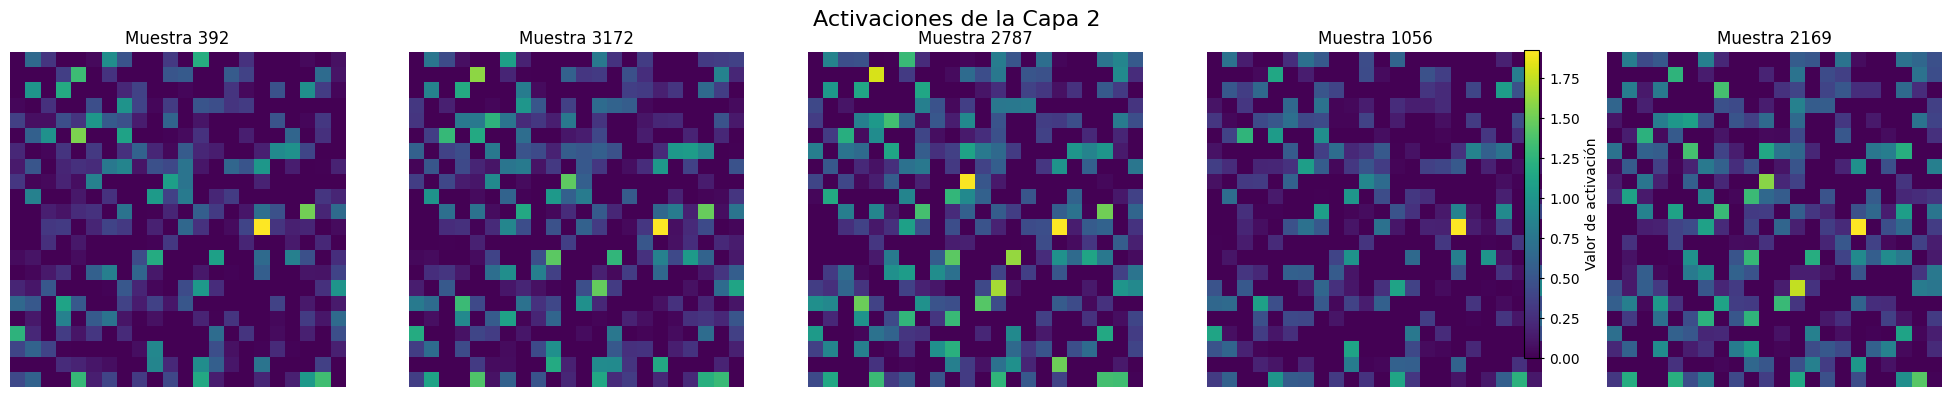

In [30]:
def ver_capa(X_muestra, capa_num=1, muestras=3):
    
   
    if not isinstance(X_muestra, torch.Tensor):
        X_tensor = torch.from_numpy(X_muestra).float().cuda()
    else:
        X_tensor = X_muestra
        
    
    if muestras > X_tensor.shape[0]:
        muestras = X_tensor.shape[0]
    
    indices = random.sample(range(X_tensor.shape[0]), muestras)
    X_seleccionado = X_tensor[indices]
    
    with torch.no_grad():
    
        h1 = X_seleccionado.mm(w1) + b1
        h1_relu = h1.clamp(min=0)
        
        if capa_num == 1:
            activaciones = h1_relu
        else:
           
            h2 = h1_relu.mm(w2) + b2
            h2_relu = h2.clamp(min=0)
            
            if capa_num == 2:
                activaciones = h2_relu
            else:
               
                h3 = h2_relu.mm(w3) + b3
                h3_relu = h3.clamp(min=0)
                activaciones = h3_relu
    
    activaciones_np = activaciones.cpu().numpy()
    
    fig, axes = plt.subplots(1, muestras, figsize=(muestras*4, 4))
    
    if muestras == 1:
        axes = [axes]
    
    for i in range(muestras):
        n_neuronas = activaciones_np.shape[1]
        lado = int(np.sqrt(n_neuronas))
        
       
        datos_viz = activaciones_np[i][:lado*lado].reshape(lado, lado)
        
      
        im = axes[i].imshow(datos_viz, cmap='viridis')
        axes[i].set_title(f"Muestra {indices[i]}")
        axes[i].axis('off')
    
    
    plt.colorbar(im, ax=axes, label='Valor de activación')
    plt.suptitle(f"Activaciones de la Capa {capa_num}", fontsize=16)
    
   
    plt.tight_layout()
    plt.show()

ver_capa(X_test, capa_num=2, muestras=5)

# Error

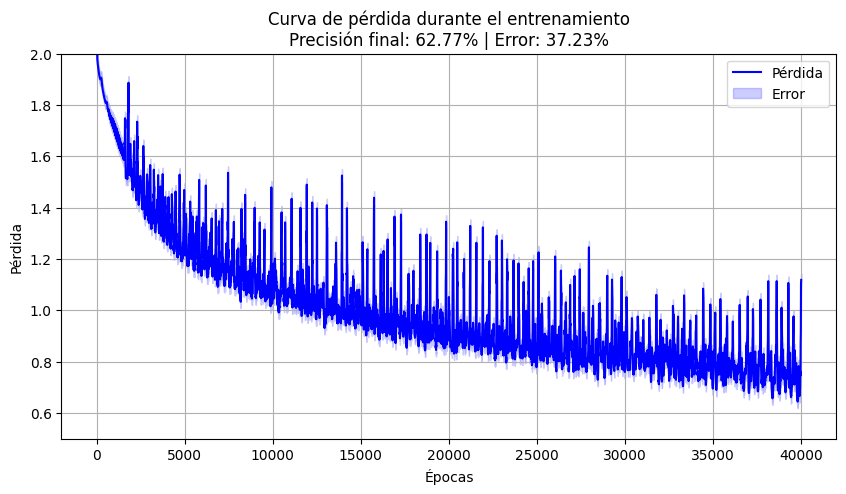

In [56]:
def plot_loss_curve(loss_history, accuracy, log_each):

    epochs = np.arange(1, len(loss_history) + 1) * log_each
    
    loss_history = [2.0] + loss_history
    epochs = np.insert(epochs, 0, 0)
    
    error_std = np.std(loss_history) * 0.1 
    loss_history = np.array(loss_history)
    
    error_percentage = 100 - accuracy
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_history, label='Pérdida', color='b')
    plt.fill_between(epochs, loss_history - error_std, loss_history + error_std, color='b', alpha=0.2, label='Error')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title(f'Curva de pérdida durante el entrenamiento\nPrecisión final: {accuracy:.2f}% | Error: {error_percentage:.2f}%')
    plt.legend()
    plt.grid()
    plt.ylim(0.50, 2.0)
    plt.show()

plot_loss_curve(loss_history, accuracy= 62.77, log_each = 10)


In [57]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())

y_pred = y_pred.cpu().numpy()

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy*100:.2f}%")


Precisión del modelo: 62.77%


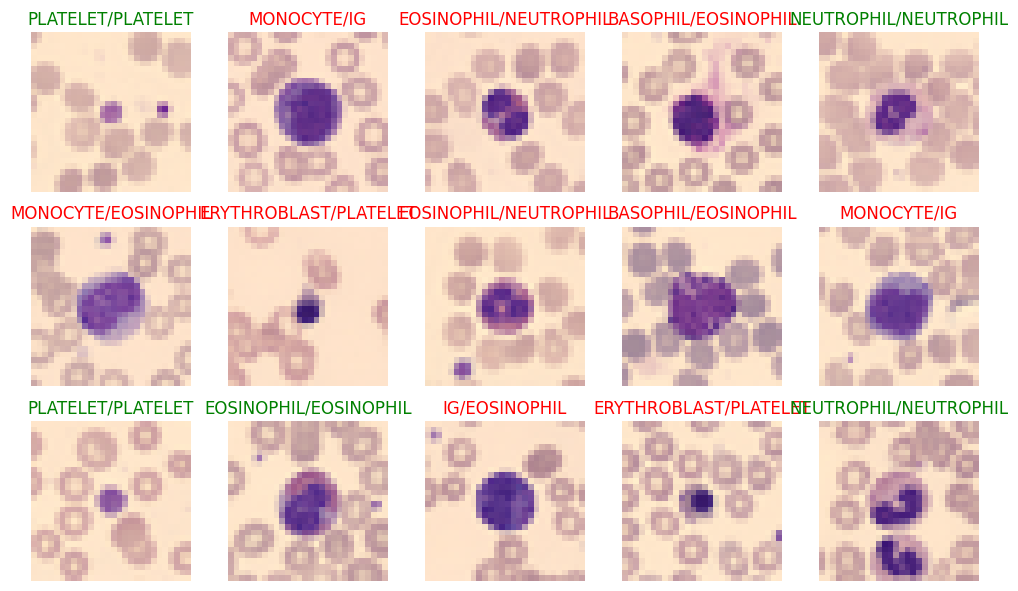

In [58]:
class_names = ['BASOPHIL', 'EOSINOPHIL', 'ERYTHROBLAST', 'IG', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL', 'PLATELET']

r, c = 3, 5
fig = plt.figure(figsize=(2 * c, 2 * r))

for i in range(r * c):
    plt.subplot(r, c, i + 1)
    
    ix = random.randint(0, len(X_test) - 1)
    img = X_test[ix]
    
    y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
    
    plt.imshow(img.reshape(28, 28, 3))
    plt.axis("off")
    
    true_class_name = class_names[y_test[ix]]
    predicted_class_name = class_names[y_pred]
    
    title_color = "green" if y_test[ix] == y_pred else "red"
    plt.title(f"{true_class_name}/{predicted_class_name}", color=title_color)

plt.tight_layout()
plt.show()